<a href="https://colab.research.google.com/github/MiladQolami/Neural-Data-Analysis/blob/main/SpikingVariablity/pandas_multielec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Multielectrode Data in pandas

If you haven't already, please read the [description](./intro_multielec_data) of the experiment that this data comes from, in the previous section.

We're going to load in the multielectrode array data from a CSV file, do some EDA, and make some inferences with respect to our experimental questions. 

## Import packages

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [20,5]

## Set known experiment parameters

In [ ]:
# times the stimulus went on and off
trial_start_time = -0.150
grating_on_time  = 0.0
grating_off_time = 2.0
trial_end_time   = 2.5

## Import the data


In [6]:
df = pd.read_csv('/content/multielectrode_data.csv')

,channel,time,orientation,trial
0,42.0,2.425,90.0,0.0
1,42.0,2.452,90.0,0.0
2,42.0,2.483,90.0,0.0
3,42.0,2.515,90.0,0.0
4,42.0,2.545,90.0,0.0
...,...,...,...,...
623401,80.0,2.586,0.0,2299.0
623402,22.0,2.591,0.0,2299.0
623403,44.0,2.600,0.0,2299.0
623404,80.0,2.600,0.0,2299.0


In [8]:
first_trial = df[df.trial == 0]

,channel,time,orientation,trial
0,42.0,2.425,90.0,0.0
1,42.0,2.452,90.0,0.0
2,42.0,2.483,90.0,0.0
3,42.0,2.515,90.0,0.0
4,42.0,2.545,90.0,0.0
5,42.0,2.727,90.0,0.0
6,42.0,2.771,90.0,0.0
7,42.0,2.774,90.0,0.0
8,42.0,2.782,90.0,0.0
9,42.0,2.802,90.0,0.0


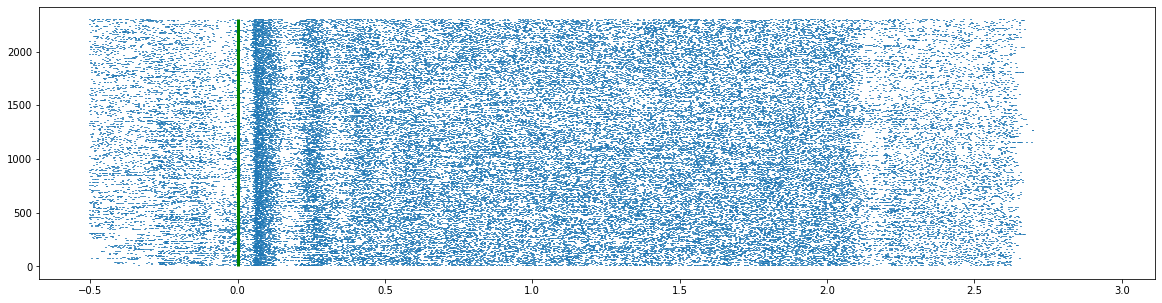

In [35]:
from pandas.core.groupby.groupby import T
trial_num = len(df.trial.unique())
spike_times = []
for i in range(trial_num):
  spike_time = df[df.trial == i].time.values
  spike_times.append(spike_time)

fig,ax = plt.subplots()
ax.eventplot(spike_times)
ax.vlines(0,0,trial_num,color = 'g',linewidth = 3)
plt.show()

### Exploring the data 


These data are again in **long format**, and they are sparse data with one row for each spike. Let's look at the head of the data to get oriented:

In [ ]:
df.head()

,channel,time,orientation,trial
0,42.0,2.425,90.0,0.0
1,42.0,2.452,90.0,0.0
2,42.0,2.483,90.0,0.0
3,42.0,2.515,90.0,0.0
4,42.0,2.545,90.0,0.0


The columns are:
- channel — which electrode the data came from
- time — spike time, relative to stimulus onset (so we have negative values for spikes that occurred during the fixation period prior to stimulus onset). This is measured in seconds
- orientation — of stimulus (0 or 90 deg)
- trial number — 1150 trials for each orientation

We can see how many rows there are in the DataFrame (as well as the number of columns, but we could already see that in this case):

In [ ]:
df.shape

(623406, 4)

In [ ]:
df.shape[0] / 20 / 2

15585.15

### Electrodes
Let's see how many electrodes we have data from, and what their labels are. We save each as a variable, which will come in handy later in looping through these.

In [ ]:
num_chan = len(df['channel'].unique())
print('Number of electrodes (channels): ' + str(num_chan))

channels = sorted(df['channel'].unique())  # use the sorted() function so the channels are listed sequentially
print('Channel labels: ' + str(channels))

Number of electrodes (channels): 20
Channel labels: [4.0, 7.0, 10.0, 22.0, 23.0, 32.0, 35.0, 42.0, 44.0, 45.0, 63.0, 67.0, 73.0, 75.0, 79.0, 80.0, 86.0, 91.0, 95.0, 96.0]


This is a bit weird — we're told this is a 96 electrode array, but there are only 15 electrodes?!  

This is because the full data set is huge, with over 2 million rows. The amount of memory that this requires makes doing anything with the data quite slow. So we've provided data for a subset of channels for the purposes of this tutorial.

### Orientations
What about orientations?

In [ ]:
orientations = sorted(df['orientation'].unique())
num_ortns = len(orientations)
print('Found ' + str(num_ortns) + ' orientations, which are: ' + str(orientations))

Found 2 orientations, which are: [0.0, 90.0]


So most channels contain activity from one neuron, but channel 20 picked up 4 neurons, and 29 and 60 each picked up 2 neurons. 

---
## Peri-Stimulus Time Histograms (PSTH)

Since we have thousands of trials, we're not going to plot rasters for this data set. Since PSTHs collapse across trials, this is a more convenient and compact way of representing spiking activity as a function of time. 

Let's start by plotting the PSTH for one channel, #4:

In [ ]:
dat = df[(df['channel'] == 4)]

We'll use pandas' `.hist()` method to obtain a PSTH, firstly just across all trials and electrodes/neurons, with the following arguments:
- `column='time'` cspecifies that the values in this column (spike times) are used to generate the histogram
- the `by='orientation'` argument generates separate plots for each value in the orientation column
- the `bins=time_bins` variable we set earlier defines the x axis of the histogram (`bins`); `time_bins` is in 10 ms increments so that becomes the size of our histogram bins
- `sharey` forces the y axis range to be the same across plots
- `layout` specifies 2 rows (each orientation) and one column
- `figsize` was determined by trial and error to provide a subjectively-nice aspect ratio and fit the figure in the notebook

### Define bin widths
One thing we need to do before creating any histograms is defining our bin widths. Although the histogram function will do this automatically, for PSTHs we want more control over the bins, specifically so that each bin corresponds to a 10 ms period. 

Recall that the spike times are in seconds, so we use 0.01 as the step size to get 10 ms bins, going from the start to the end of the trial. 

In [ ]:
# Create a set of 10 ms bins for our PSTHs, spanning the time range of each trial
time_bins = np.arange(trial_start_time, trial_end_time, 0.01)

### Plot the PSTH

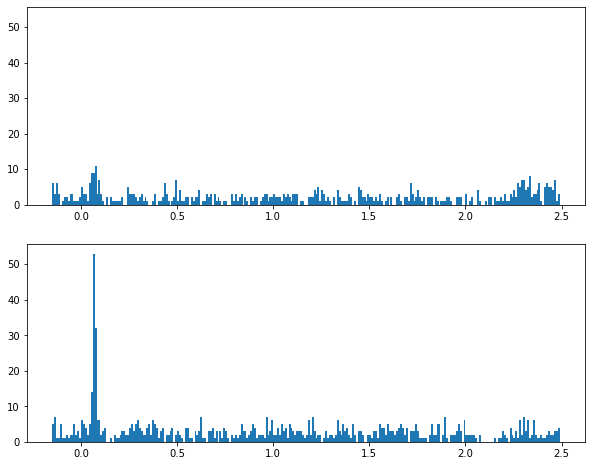

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=[10, 8], sharey=True)

for idx, ori in enumerate(orientations):
    axs[idx].hist(dat[dat['orientation'] == ori]['time'], 
                 bins=time_bins)

plt.show()

### Plot both orientations overlaid

For this we use the kwarg `histtype='step'` to draw the histograms as lines rather than bars:

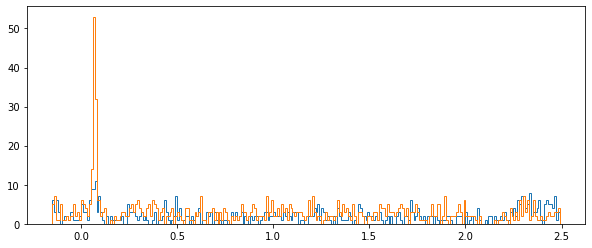

In [ ]:
fig, axs = plt.subplots(figsize=[10, 4], sharey=True)

for idx, ori in enumerate(orientations):
    axs.hist(dat[dat['orientation'] == ori]['time'], 
                  bins=time_bins,
                  histtype='step' 
                 )
    

plt.show()

## Make array of histograms

The above examples were OK for one channel, but it would be nice to have more control over the plots and be able to easily work with all of the data at once. 

To facilitate this, we'll make a NumPy array of histograms similar to what we did in the heat maps lesson. However, in this case the rows of the array are not intensity levels, but each combination of channel and orientation. We're not going to use this array to plot heat maps (since the rows here aren't levels of a continuous variable), but just to store the histograms to make it easy to plot them later.

After we make the NumPy array we convert it into a pandas DataFrame, which allows us to make the column labels the actual time points that each bin starts with.

In [ ]:
df_list = []

# Initialize hitogram array
# bins are edges, so there is 1 less value in histogram than in bins
hist_arr = np.zeros([num_chan * num_ortns, 
                     len(time_bins)-1]  
                   )

# initialize row index variable to increase each time through the loop
r_idx = 0

for chan in channels:
    for ori in orientations:
        hist_arr[r_idx], bins = np.histogram(df[(df['channel']==chan) & (df['orientation']==ori)]['time'],
                                             bins=time_bins)
        r_idx += 1 # increment counter for next row
        
# Convert to pandas DataFrame with time values as column labels   
# We'll round the time values so that they don't have reallly long decimal places
df_psth = pd.DataFrame(hist_arr,
                      columns=np.round(time_bins[:-1], 3))        

In [ ]:
df_psth.head()

,-0.15,-0.14,-0.13,-0.12,-0.11,-0.10,-0.09,-0.08,-0.07,-0.06,...,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48
0,6.0,3.0,6.0,3.0,0.0,1.0,2.0,2.0,1.0,3.0,...,1.0,0.0,5.0,6.0,5.0,5.0,4.0,7.0,1.0,3.0
1,5.0,7.0,1.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,2.0,1.0,1.0,2.0,3.0,2.0,2.0,3.0,3.0,4.0
2,7.0,7.0,8.0,10.0,6.0,5.0,3.0,3.0,1.0,1.0,...,1.0,2.0,5.0,4.0,1.0,1.0,1.0,2.0,4.0,5.0
3,9.0,7.0,7.0,9.0,4.0,4.0,3.0,4.0,2.0,3.0,...,0.0,2.0,1.0,3.0,5.0,3.0,3.0,7.0,1.0,5.0
4,21.0,29.0,24.0,18.0,13.0,7.0,7.0,7.0,3.0,9.0,...,11.0,17.0,9.0,7.0,14.0,12.0,15.0,15.0,11.0,11.0


### Create columns of labels
Next we'll add columns for channel and orientation labels.

To make this DataFrame, first we'll create a DataFrame of the two columns of labels we want (channel and orientation) and then we'll concatenate that with the NumPy array. 

In [ ]:
labels_tmp = []

for chan in channels:
    for ori in orientations:
        labels_tmp.append([chan, ori])
        
condition_labels = pd.DataFrame(labels_tmp, 
                                columns=['channel', 'orientation'])

condition_labels.head(8)

,channel,orientation
0,4.0,0.0
1,4.0,90.0
2,7.0,0.0
3,7.0,90.0
4,10.0,0.0
5,10.0,90.0
6,22.0,0.0
7,22.0,90.0


Then we can merge the labels and histograms with `pd.concat()`. The first argumrnt to `pd.concat()` is a list of the DataFrames you want to merge, and the `axis=1` kwarg is used to specify that we want to merge by columns (add the two DataFrames side-by-side, instead of one on top of the other).

Note that we don't assign the output to a new variable, we just view the head, because we're actually going to make the final version of this DataFrame a different way below.

In [ ]:
pd.concat([condition_labels, df_psth], axis=1).head()

,channel,orientation,-0.15,-0.14,-0.13,-0.12,-0.11,-0.1,-0.09,-0.08,...,2.39,2.4,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48
0,4.0,0.0,6.0,3.0,6.0,3.0,0.0,1.0,2.0,2.0,...,1.0,0.0,5.0,6.0,5.0,5.0,4.0,7.0,1.0,3.0
1,4.0,90.0,5.0,7.0,1.0,1.0,5.0,1.0,1.0,2.0,...,2.0,1.0,1.0,2.0,3.0,2.0,2.0,3.0,3.0,4.0
2,7.0,0.0,7.0,7.0,8.0,10.0,6.0,5.0,3.0,3.0,...,1.0,2.0,5.0,4.0,1.0,1.0,1.0,2.0,4.0,5.0
3,7.0,90.0,9.0,7.0,7.0,9.0,4.0,4.0,3.0,4.0,...,0.0,2.0,1.0,3.0,5.0,3.0,3.0,7.0,1.0,5.0
4,10.0,0.0,21.0,29.0,24.0,18.0,13.0,7.0,7.0,7.0,...,11.0,17.0,9.0,7.0,14.0,12.0,15.0,15.0,11.0,11.0


### Advanced approach: Using list comprehension

The above steps work fine, but gust for fun, here's a tricky but elegant *nested list comprehension* way of doing this. Recall that a list comprehension is essentially a `for` loop inside a set of square brackets, that creates a list. But just as we can nest one `for` loop inside another, we can nest `for` statements inside list comprehensions, to create a list of lists, and then convert that to a pandas DataFrame, all in one line of code.

In [ ]:
condition_labels = pd.DataFrame([[chan, ori] for chan in channels for ori in orientations ],
                               columns=['channel', 'orientation'])

condition_labels.head(8)

,channel,orientation
0,4.0,0.0
1,4.0,90.0
2,7.0,0.0
3,7.0,90.0
4,10.0,0.0
5,10.0,90.0
6,22.0,0.0
7,22.0,90.0


#### Add labels to histograms DataFrame with list comprehension

The cool thing about the list comprehension approach is that we don't need to separately make a DataFrame of labels and then merge that with the DataFrame of histograms; instead, we can just pass the list comprehension as two new channels of the DataFrame, all in one step. 

This works because the list comprehension runs in a single line of code, and because pandas will interpret each entry in a list of list as a row in a DataFrame. We just have to be sure to assign the results of the list comprehension to a list of column labels. That is, below we use 

    df_psth[['channel', 'orientation']]

and not 

    df_psth['channel', 'orientation']


In [ ]:
df_psth[['channel', 'orientation']] = [[chan, ori] for chan in channels for ori in orientations]

Finally, since we have wide-format data here, and the two columns we just added are labels, we will make these two columns indexes of the DataFrame. This will make working with it easier later on.

In [ ]:
df_psth = df_psth.set_index(['channel', 'orientation'])

df_psth.head()

-0.15  -0.14  -0.13  -0.12  -0.11  -0.10  -0.09  -0.08  \
channel orientation                                                           
4.0     0.0            6.0    3.0    6.0    3.0    0.0    1.0    2.0    2.0   
        90.0           5.0    7.0    1.0    1.0    5.0    1.0    1.0    2.0   
7.0     0.0            7.0    7.0    8.0   10.0    6.0    5.0    3.0    3.0   
        90.0           9.0    7.0    7.0    9.0    4.0    4.0    3.0    4.0   
10.0    0.0           21.0   29.0   24.0   18.0   13.0    7.0    7.0    7.0   

                     -0.07  -0.06  ...   2.39   2.40   2.41   2.42   2.43  \
channel orientation                ...                                      
4.0     0.0            1.0    3.0  ...    1.0    0.0    5.0    6.0    5.0   
        90.0           1.0    2.0  ...    2.0    1.0    1.0    2.0    3.0   
7.0     0.0            1.0    1.0  ...    1.0    2.0    5.0    4.0    1.0   
        90.0           2.0    3.0  ...    0.0    2.0    1.0    3.0    5.0   
10.0    0.0            3.0    9.0  ...   11.0   17.0    9.0    7.0   14.0   

                      2.44   2.45   2.46   2.47   2.48  
channel orientation                                     
4.0     0.0            5.0    4.0    7.0    1.0    3.0  
        90.0           2.0    2.0    3.0    3.0    4.0  
7.0     0.0            1.0    1.0    2.0    4.0    5.0  
        90.0           3.0    3.0    7.0    1.0    5.0  
10.0    0.0           12.0   15.0   15.0   11.0   11.0  

[5 rows x 264 columns]

### Plotting the Histograms

Now we can plot the histograms that we just completed. These should look similar to the panel of 8 histograms we plotted above; the big difference is that above we use pandas `.histogram()` method, whereas here we pre-computed the histograms so that we can use Matplotlib's more flexible and general-purpose `.plot()` function. This allows us more control and power in drawing the plot. For example, below we shade in the time period when the stimulus was on, and we draw the PSTHs as lines rather than bars. Although this may seem like something of an aesthetic preference, as you'll see below, lines give you the ability to overlay PSTHs for different conditions, allowing comparison.

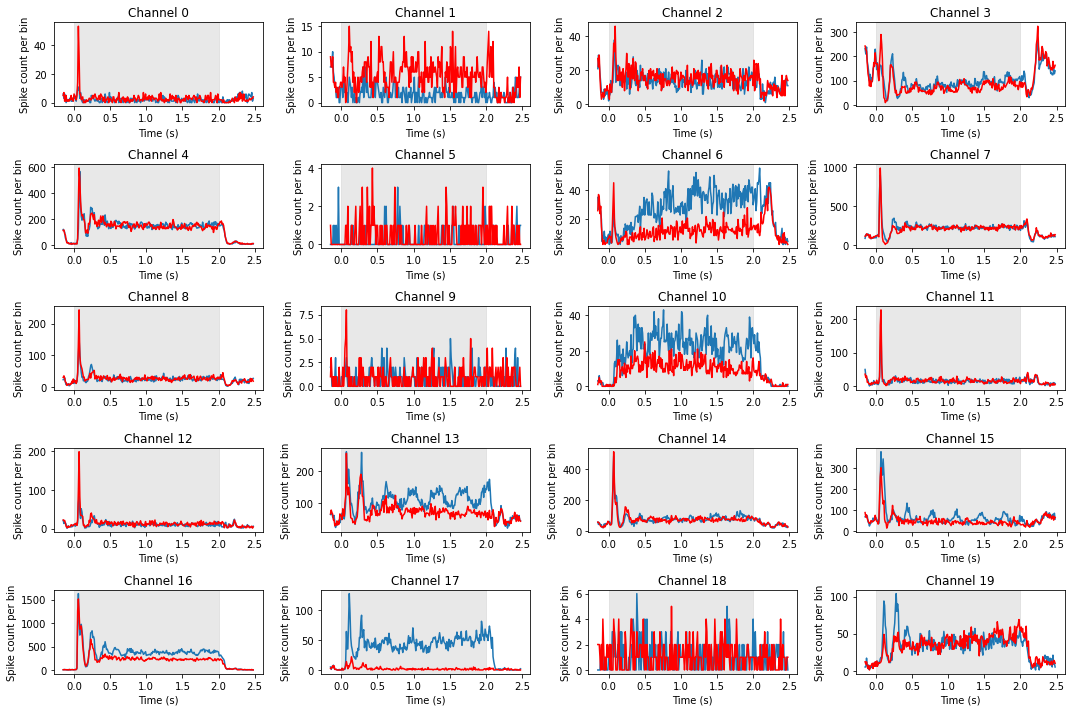

In [ ]:
# We know there are 20 channels so define a 5 x 4 array of subplots
fig, axs = plt.subplots(5, 4, figsize=[15, 10])

# Use enumerate to loop through channels
for chan, ax in enumerate(axs.reshape(-1)):
    # 0 deg orienation
    ax.plot(time_bins[:-1], 
           df_psth.loc[(channels[chan], orientations[0])]
           )

    # 90 deg orientation
    ax.plot(time_bins[:-1], 
           df_psth.loc[(channels[chan], orientations[1])],
           color='red'
           )

    ax.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
    ax.set_title('Channel ' + str(chan))
    ax.set_ylabel('Spike count per bin')
    ax.set_xlabel('Time (s)')
        

plt.tight_layout() 
plt.show()    

Note above the differences in total spike counts (*y* axis ranges) between sort codes. This is because the data are summed over channels; every channel as at least a sort code of 1 (i.e., contains data from one neuron/unit), but fewer channels were found to contain data from two or more units. So decreasing amounts of data contribute to the averages for sort codes 1-4.

One thing you'll note above is that there are some missing panels, including channels 21, 31, 34, 56, and 68. As noted above, these are the dead channels. The way the code above is written, we use the channel number as the index for the subplot position. Since there is no channel in the `channels` list for the dead channels, those subplot panels are simply left blank.

Beyond that, it's clear that different channels show very different response profiles. Some (e.g., 1, 2, 4, 5) show clear transient peaks in spiking activity soon after stimulus onset. Others do not. Some of the channels that show this initial peak return to baseline (low) levels of firing soon after, while others (e.g., 1, 20, 72) show a sustained plateau as long as the stimulus is on. Others (e.g., 3, 62) show no initial peak, but a steady rise in firing rate as the stimulus duration increases. As well, a few channels show orientation sensitivity, with clearly different responses between 0 (blue) and 90 (red) degree gratings (e.g., 29, 63, 75, 76, 91).

## Interpreting the data